# Astrostatistics Lab 1: Hubble Data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.table as at
import astropy.units as au

## Colors

The two colors were chosen to be distinct to colorblind readers. We're able to include them in Matplotlib's color mapping by injecting them into `matplotlib.colors._colors_full_map`, which I find nicer than keeping global variables around. This is probably dangerous in case the internal API changes in the future.

In [2]:
matplotlib.colors._colors_full_map.update({
    "custom:primary": "#932666",
    "custom:secondary": "#4d671b"
})

# Plot Setup

To plot astropy unit-aware `Quantity` objects in matplotlib, we need to call `quantity_support()` before calling anything. We configure `matplotlib` to use LaTeX for beautiful text and math formatting in our plots.

In [3]:
from cycler import cycler
from astropy.visualization import quantity_support
quantity_support()

# Preamble for shorter minus signs adapted from https://tex.stackexchange.com/a/4777
MINUS_PREAMBLE = r"""
\usepackage{xparse}

\makeatletter
\NewDocumentCommand{\shortminus}{m}{%
  \raisebox{0.13em}{$\m@th#1{-}\mkern-1mu$}%
}
\NewDocumentCommand{\unaryminus}{}{%
  \mathbin{%
    \mathchoice{%
      \shortminus\scriptstyle
    }{%
      \shortminus\scriptstyle
    }{%
      \shortminus\scriptscriptstyle
    }{%
      \shortminus\scriptscriptstyle
    }%
  }%
}
\makeatother
"""

CUSTOM_PLOT_STYLE = {
    "text.usetex": True,
    "text.latex.preamble": MINUS_PREAMBLE,

    "font.family": "serif",
    "font.serif": ["Computer Modern Serif", *matplotlib.rcParamsDefault["font.serif"]],
    "font.size": 16,

    "mathtext.fontset": "cm",

    # Turn off the right and top spines so we don't get the "box" look
    "axes.spines.right": False,
    "axes.spines.top": False,

    # Set the default plotting color to the ones we defined above
    "axes.prop_cycle": cycler(color=("custom:primary", "custom:secondary",)),

    # Set some default sizes, so we don't need to include them in each call
    "lines.markersize": 5,
    "lines.linewidth": 1.5,
    "errorbar.capsize": 3,

    # Set savefig to use bbox_inches="tight" by default
    "savefig.bbox": "tight",
    "savefig.facecolor": "none"
}

matplotlib.rcdefaults()
matplotlib.rcParams.update(CUSTOM_PLOT_STYLE)

In [4]:
matplotlib.rcParams["savefig.facecolor"]

'none'

# Reading the data

We read in the data into an astropy `Table`. We need to skip 7 lines of the header in the dat file.

In [5]:
HUBBLE_DATA = at.Table.read("Hubble data/data.dat", data_start=7, names=("distance", "e_distance",
                            "velocity"), guess=False, format="csv", delimiter="\t")

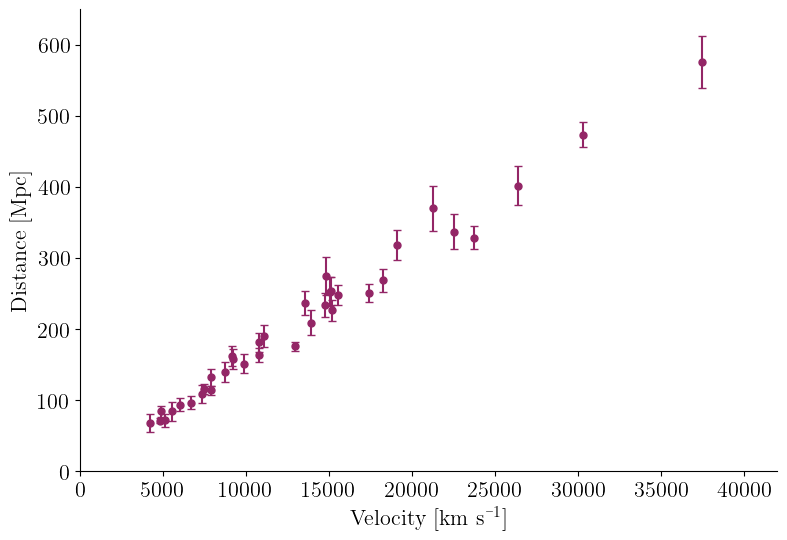

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(HUBBLE_DATA["velocity"], HUBBLE_DATA["distance"], yerr=HUBBLE_DATA["e_distance"], fmt="o")

ax.set_ylim(0 * au.Mpc, 650 * au.Mpc)
ax.set_ylabel("Distance [Mpc]")

ax.set_xlim(0 * au.km / au.s, 42000 * au.km / au.s)
ax.set_xlabel("Velocity [km s$^{\\unaryminus 1}$]")

plt.show()

# Doing an unweighted fit

We can use `np.polyfit` to do a linear least-squares fit on the data.

In [7]:
fit_coeffs = np.polyfit(HUBBLE_DATA["velocity"], HUBBLE_DATA["distance"], deg=1)
fit_coeffs

array([0.015319  , 5.79111286])

We can also "manually" do the fit using the matrix formula from class. This should give us the same result as `polyfit`.

$$\left(X^\mathsf{T}X\right)\beta = X^\mathsf{T}y$$

In [8]:
X = np.column_stack((
    HUBBLE_DATA["velocity"],
    np.ones_like(HUBBLE_DATA["velocity"])
))

# The @ operator is short for np.dot
fit_coeffs_manual = np.linalg.solve(X.T @ X, X.T @ HUBBLE_DATA["distance"])
fit_coeffs_manual

array([0.015319  , 5.79111286])

Turn the fit coefficients into the newer `np.polynomial.Polynomial` class so can call it on our data like `fit_poly(x)`.

In [9]:
# the Polynomial class expects the coefficients written in order of increasing degree
fit_poly = np.polynomial.Polynomial(fit_coeffs[::-1])
fit_poly

Polynomial([5.79111286, 0.015319  ], domain=[-1,  1], window=[-1,  1], symbol='x')

Plot the fit along with the data

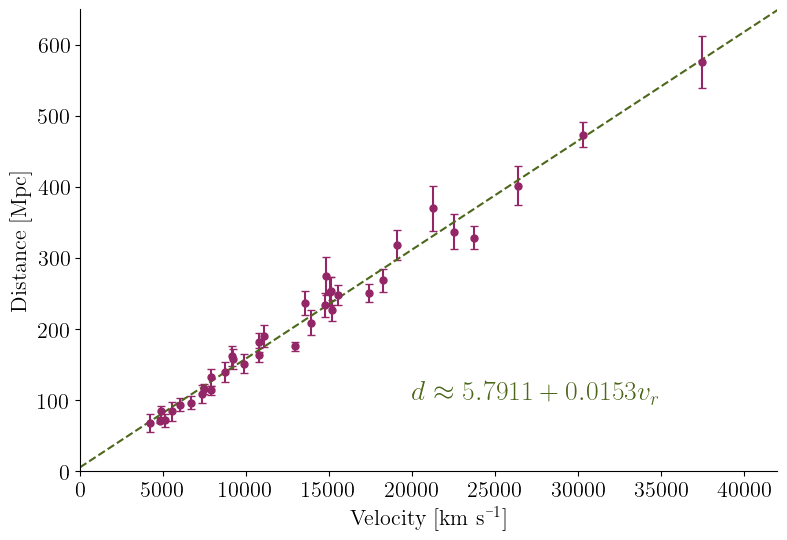

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(HUBBLE_DATA["velocity"], HUBBLE_DATA["distance"], yerr=HUBBLE_DATA["e_distance"], fmt="o")

ax.set_ylim(0, 650)
ax.set_ylabel("Distance [Mpc]")

ax.set_xlim(0, 42000)
ax.set_xlabel("Velocity [km s$^{\\unaryminus 1}$]")

ax.plot(ax.get_xlim(), fit_poly(np.array(ax.get_xlim())), "--")

ax.text(20000, 100, f"$d \\approx {fit_coeffs[1]:.4f} + {fit_coeffs[0]:.4f}v_r$", color="custom:secondary", fontsize=20)

plt.show()

# Residual plot

To make a residual plot under the main plot, we make two axes in a single column with `plt.subplot`, and set the `sharex` attribute to keep the same x-axis.

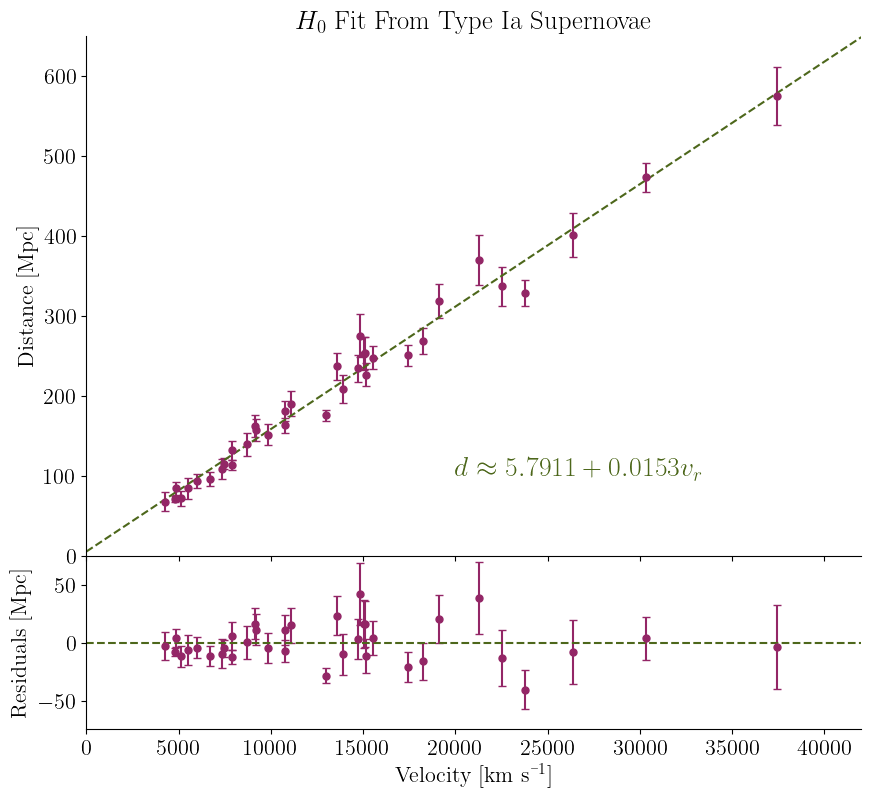

In [11]:
fig, (ax, ax_residuals) = plt.subplots(2, 1, sharex=True, figsize=(10, 9), height_ratios=[0.75, 0.25])

# This removes the gap between the top and bottom plots, but allows the tick markings to show on the top plot still
fig.subplots_adjust(hspace=0.)
ax_residuals.set_zorder(-1)

ax.errorbar(HUBBLE_DATA["velocity"], HUBBLE_DATA["distance"], yerr=HUBBLE_DATA["e_distance"], fmt="o")

ax.set_ylim(0, 650)
ax.set_ylabel("Distance [Mpc]")

ax.set_title("$H_0$ Fit From Type Ia Supernovae")

ax.set_xlim(0 * au.km / au.s, 42000 * au.km / au.s)

ax.plot(ax.get_xlim(), fit_poly(np.array(ax.get_xlim())), "--")
ax.text(20000, 100, f"$d \\approx {fit_coeffs[1]:.4f} + {fit_coeffs[0]:.4f}v_r$", color="custom:secondary", size=20)

# The residual plot is the same as the main data, but with the model fit subtracted 
ax_residuals.errorbar(HUBBLE_DATA["velocity"], HUBBLE_DATA["distance"] - fit_poly(HUBBLE_DATA["velocity"]), yerr=HUBBLE_DATA["e_distance"], fmt="o")
ax_residuals.set_xlabel("Velocity [km s$^{\\unaryminus 1}$]")
ax_residuals.set_ylabel("Residuals [Mpc]")
ax_residuals.set_ylim(-75, 75)

ax_residuals.hlines(0, *ax_residuals.get_xlim(), linestyle="dashed", color="custom:secondary")

plt.savefig("figures/F2.png")

plt.show()

# Weighted fit

We can do a weighted fit by modifying the equation from before to include the matrix $W$ with the weights along the diagonal. We weight by the inverse of weight squared.
$$\left(X^\mathsf{T} W X\right)\beta = X^\mathsf{T} W y$$
$$\beta = \left(X^\mathsf{T} W X\right)^{-1} X^\mathsf{T} W y$$

The inverted term is our covariance matrix

$$
\left(X^\mathsf{T} W X\right)^{-1} = \begin{bmatrix}
\sigma_m^2 & \sigma_m \sigma_b \\
\sigma_m \sigma_b & \sigma_b^2
\end{bmatrix}
$$

In [12]:
weights = 1/HUBBLE_DATA["e_distance"]**2
W = np.diag(weights)

cov = np.linalg.inv(X.T @ W @ X)
fit_poly_weighted_manual = np.polynomial.Polynomial((cov @ X.T @ W @ HUBBLE_DATA["distance"])[::-1])
fit_poly_weighted_manual

Polynomial([0.47926143, 0.01521935], domain=[-1,  1], window=[-1,  1], symbol='x')

In [13]:
cov

array([[ 1.20926068e-07, -1.06883875e-03],
       [-1.06883875e-03,  1.25574519e+01]])

We can verify this with `polyfit`, making sure to pass the *unsquared* reciprocals of error as `w` and `cov="unscaled"` (`cov=True` applies scaling based on degrees of freedom).

In [14]:
fit_coeffs_weighted, polyfit_cov = np.polyfit(HUBBLE_DATA["velocity"], HUBBLE_DATA["distance"], deg=1, w=1/HUBBLE_DATA["e_distance"], cov="unscaled")
fit_poly_weighted = np.polynomial.Polynomial(fit_coeffs_weighted[::-1])
fit_poly_weighted

Polynomial([0.47926143, 0.01521935], domain=[-1,  1], window=[-1,  1], symbol='x')

In [15]:
polyfit_cov

array([[ 1.20926068e-07, -1.06883875e-03],
       [-1.06883875e-03,  1.25574519e+01]])

# Putting it all together

We make a graph with both the unweighted and weighted fits shown and two residual plots. We estimate the age of the universe as

$$t_0 = \frac{1}{H_0}$$

where $H_0$ is the gradient of our fit.

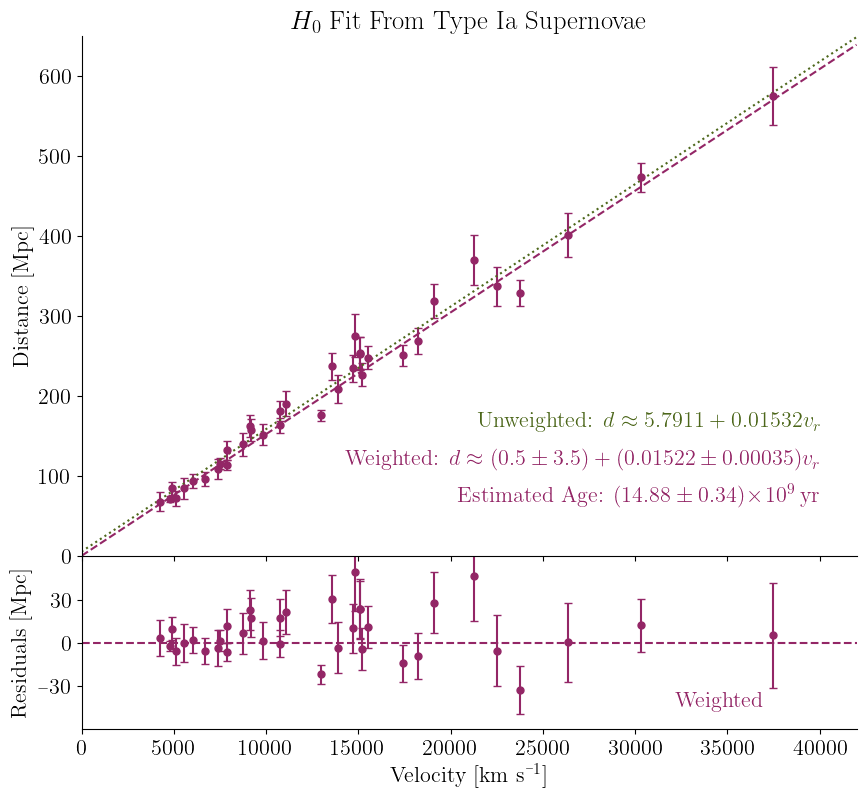

In [16]:
fig, (ax, ax_residuals) = plt.subplots(2, 1, sharex=True, figsize=(10, 9), height_ratios=[0.75, 0.25])
fig.subplots_adjust(hspace=0.)
ax_residuals.set_zorder(-1)
# ax_residuals2.set_zorder(-2)

ax.errorbar(HUBBLE_DATA["velocity"], HUBBLE_DATA["distance"], yerr=HUBBLE_DATA["e_distance"], fmt="o", color="custom:primary")

ax.set_ylim(0, 650)
ax.set_ylabel("Distance [Mpc]")
ax.set_title("$H_0$ Fit From Type Ia Supernovae")

ax.set_xlim(0, 42000)

ax.plot(ax.get_xlim(), fit_poly(np.array(ax.get_xlim())), ":", color="custom:secondary")
ax.plot(ax.get_xlim(), fit_poly_weighted(np.array(ax.get_xlim())), "--", color="custom:primary")

kw = { "horizontalalignment": "right", "verticalalignment": "top"}
ax.text(40000, 180, f"Unweighted: $d \\approx {fit_coeffs[1]:.4f} + {fit_coeffs[0]:.5f}v_r$", color="custom:secondary", **kw)
ax.text(40000, 135, f"Weighted: $d \\approx ({fit_coeffs_weighted[1]:.1f} \\pm {np.sqrt(cov[1, 1]):.1f}) + ({fit_coeffs_weighted[0]:.5f} \\pm {np.sqrt(cov[0, 0]):.5f})v_r$", color="custom:primary", **kw)

# use astropy.units for our unit conversion to years
estimated_age = (fit_coeffs_weighted[0] * au.Mpc * au.s / au.km).to_value(au.year)
estimated_age_error = (np.sqrt(cov[0, 0]) * au.Mpc * au.s / au.km).to_value(au.year)

ax.text(40000, 90, f"Estimated Age: $({estimated_age/1e9:.2f} \pm {estimated_age_error/1e9:.2f})\\!\\times\\!10^9\>\\mathrm{{yr}}$", color="custom:primary", **kw)

# Plot the residuals from the weighted fit on the first residual plot
ax_residuals.errorbar(HUBBLE_DATA["velocity"], (HUBBLE_DATA["distance"] - fit_poly_weighted(HUBBLE_DATA["velocity"])), yerr=HUBBLE_DATA["e_distance"], fmt="o", color="custom:primary")
ax_residuals.set_ylim(-60, 60)
ax_residuals.set_yticks([-30, 0, 30])
ax_residuals.hlines(0, *ax_residuals.get_xlim(), linestyle="dashed", color="custom:primary")
ax_residuals.text(0.88, 0.1, f"Weighted", color="custom:primary", transform=ax_residuals.transAxes, verticalalignment="bottom", horizontalalignment="right")

ax_residuals.set_ylabel("Residuals [Mpc]")
ax_residuals.set_xlabel("Velocity [km s$^{\\unaryminus 1}$]")

# Plot the residuals from the unweighted fit on the second residual plot
# ax_residuals2.errorbar(HUBBLE_DATA["velocity"], (HUBBLE_DATA["distance"] - fit_poly(HUBBLE_DATA["velocity"])), yerr=HUBBLE_DATA["e_distance"], fmt="o", color="custom:secondary")
# ax_residuals2.set_ylim(-60, 60)
# ax_residuals2.set_yticks([-30, 0, 30])
# ax_residuals2.hlines(0, *ax_residuals.get_xlim(), linestyle="dotted", color="custom:secondary")
# ax_residuals2.text(0.88, 0.1, f"Unweighted", color="custom:secondary", transform=ax_residuals2.transAxes, verticalalignment="bottom", horizontalalignment="right")

# ax_residuals.set_ylabel("")

# ax_residuals2.set_xlabel("Velocity [km s$^{\\unaryminus 1}$]")
# ax_residuals2.set_ylabel("Residuals [Mpc]")
# ax_residuals2.yaxis.set_label_coords(-0.075, 73.5 / 72.0)

better_tick_labels = ["${\\unaryminus\mkern+1mu 30}$", "0", "30"]
ax_residuals.set_yticklabels(better_tick_labels)
# ax_residuals2.set_yticklabels(better_tick_labels)

plt.savefig("figures/F3.png")

plt.show()


In [17]:
np.sqrt(cov[0, 0])

0.00034774425666799446

# Bootstrapping

Perturb the data points based on the error many times and sample the gradient to get an alternative distribution for the gradient. 

In [18]:
NUM_TRIALS = 100000
trials = np.empty((NUM_TRIALS, 2))

# Used a fix seed RNG generator for reproducible results
rg = np.random.default_rng(24)

W = np.diag(1 / HUBBLE_DATA["e_distance"]**2)
for i in range(NUM_TRIALS):
    Y = HUBBLE_DATA["distance"] + rg.normal(0, HUBBLE_DATA["e_distance"])
    trials[i, :] = np.linalg.solve(X.T @ W @ X, X.T @ W @ Y)

# the gradients are stored in the first column
gd = trials[:, 0]

print(f"Gradient fit: {fit_coeffs_weighted[0]:.7f}, error {np.sqrt(cov[0, 0]):.7f}")
print(f"Bootstrapping mean: {gd.mean():.7f}, standard deviation: {gd.std():.7f}")

Gradient fit: 0.0152194, error 0.0003477
Bootstrapping mean: 0.0152196, standard deviation: 0.0003492


These are the similar results as in the fit and covariance matrix from before! We can plot a histrogram and overlay a normal distribution that approximates it.

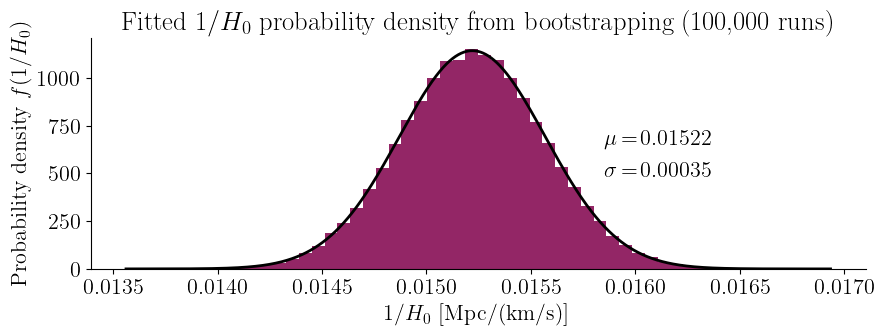

In [39]:
import scipy.stats

fig, ax = plt.subplots(figsize=(10, 3))
ax.hist(gd, bins=50, density=True)
gx = np.linspace(*ax.get_xlim(), 1000)
ax.plot(gx, scipy.stats.norm(gd.mean(), gd.std()).pdf(gx), "black", linewidth=2)

ax.set_title("Fitted $1 / H_0$ probability density from bootstrapping (100,000 runs)")
ax.set_xlabel("$1 / H_0$ [Mpc/(km/s)]")
ax.set_ylabel("Probability density $f(1 / H_0)$")

ax.text(0.8, 0.6, f"\\begin{{eqnarray*}} \\mu\\hspace{{-0.5em}}&=&\\hspace{{-0.5em}}{gd.mean():.5f} \\\\ \\sigma \\hspace{{-0.5em}}&=&\\hspace{{-0.5em}} {gd.std():.5f} \\end{{eqnarray*}}", color="black", transform=ax.transAxes, textsi **kw)

plt.savefig("figures/F4.png")
plt.show()

In [25]:
print(f"\\begin{{align*}}\\mu &= {gd.mean():.5f} \\\\ \\sigma &= \\end{{align*}}")

\begin{align*}\mu &= 0.01522 \\ \sigma &= \end{align*}


# Effect of censoring data

In [53]:
NUM_TRIALS = 256

N = len(HUBBLE_DATA["velocity"])
new_gradients = np.empty((N-2, NUM_TRIALS))
new_errors = np.empty((N-2, NUM_TRIALS))

# Used a fix seed RNG generator for reproducible results
rg = np.random.default_rng(24)

_mask_1d = np.ones_like(HUBBLE_DATA["velocity"], dtype=np.bool_)
mask = np.ones_like(W, dtype=np.bool_)
weights_masked = np.ma.MaskedArray(W, mask=mask, fill_value=0.0)

def randomize_mask(n):
    _mask_1d[:] = False
    _mask_1d[rg.choice(N, n, replace=False)] = True
    np.fill_diagonal(mask, _mask_1d)

for missing, i in np.ndindex(new_errors.shape):
    randomize_mask(missing)
    Wm = weights_masked.filled()
    new_cov = np.linalg.inv(X.T @ Wm @ X)
    new_errors[missing, i] = np.sqrt(new_cov[0, 0])
    new_gradients[missing, i] = (new_cov @ X.T @ Wm @ HUBBLE_DATA["distance"])[0]

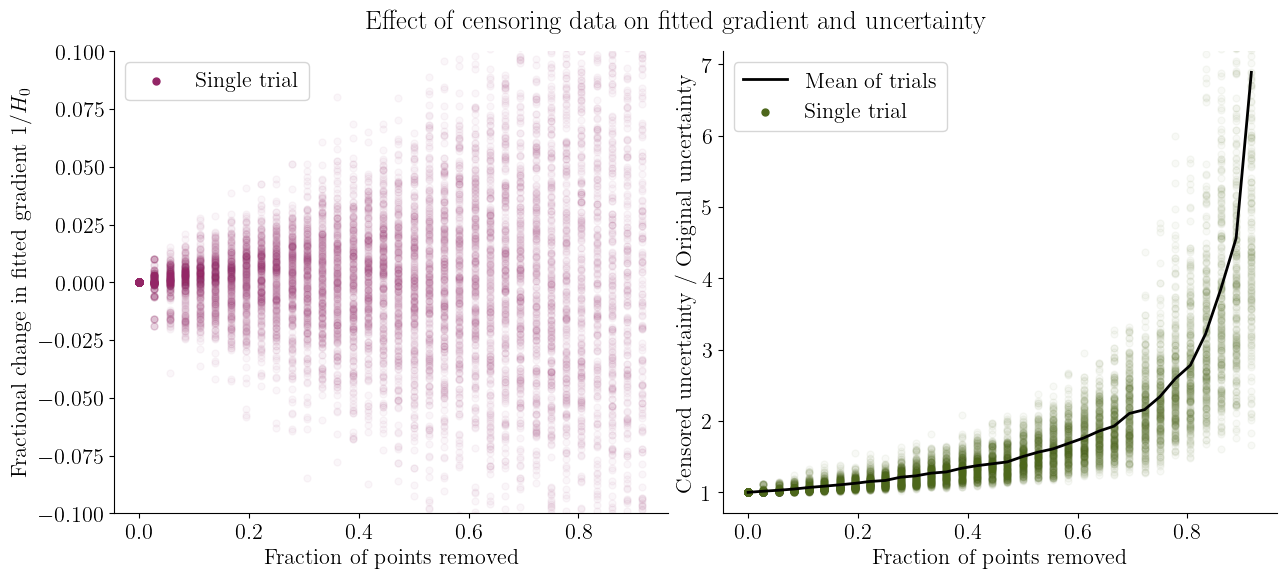

In [64]:
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.1)

error_factor = new_errors / np.sqrt(polyfit_cov[0, 0])
gradient_factor = 1.0 - (new_gradients / fit_coeffs_weighted[0])
ax.plot(np.arange(N-2)/N, error_factor.mean(axis=1), color="black", linewidth=2, label="Mean of trials")
saved_lim = ax.get_ylim()
ax.scatter(np.repeat(np.arange(N-2)/N, NUM_TRIALS), error_factor.ravel(), color="custom:secondary", alpha=0.04, label="Single trial")
ax1.scatter(np.repeat(np.arange(N-2)/N, NUM_TRIALS), gradient_factor.ravel(), color="custom:primary", alpha=0.04, label="Single trial")
ax.set_ylim(saved_lim)
ax1.set_ylim(-0.1, 0.1)

ax1.set_ylabel("Fractional change in fitted gradient $1 / H_0$")
ax1.set_xlabel("Fraction of points removed")

ax.set_ylabel("Censored uncertainty / Original uncertainty")
ax.set_xlabel("Fraction of points removed")

l = ax.legend()
l1 = ax1.legend()

# Make the dots in the legends opaque instead of transparent
for lh in (*l.legendHandles, *l1.legendHandles):
    lh.set_alpha(1.0)

fig.suptitle("Effect of censoring data on fitted gradient and uncertainty", y=0.95)

plt.savefig("figures/F5.png")
plt.show()

# Effect of adding new data point

In [76]:
HUBBLE_DATA.sort("velocity")

N = 1000
Ex = np.linspace(0, HUBBLE_DATA["velocity"].max() + 1000, N)
errors = np.empty((N,))
gradients = np.empty((N,))
weights = 1/HUBBLE_DATA["e_distance"]**2

def new_error(i, x, w):
    Xnew = np.append(X, (x,), axis=0)
    Wnew = np.diag(np.append(weights, w))
    
    return np.sqrt(np.linalg.inv(Xnew.T @ Wnew @ Xnew)[0, 0])

for i, x in enumerate(Ex):
    e = HUBBLE_DATA["e_distance"][np.argmin(np.abs(HUBBLE_DATA["velocity"]-x))]
    errors[i] = new_error(i+1, (x, 1), 1/e**2)

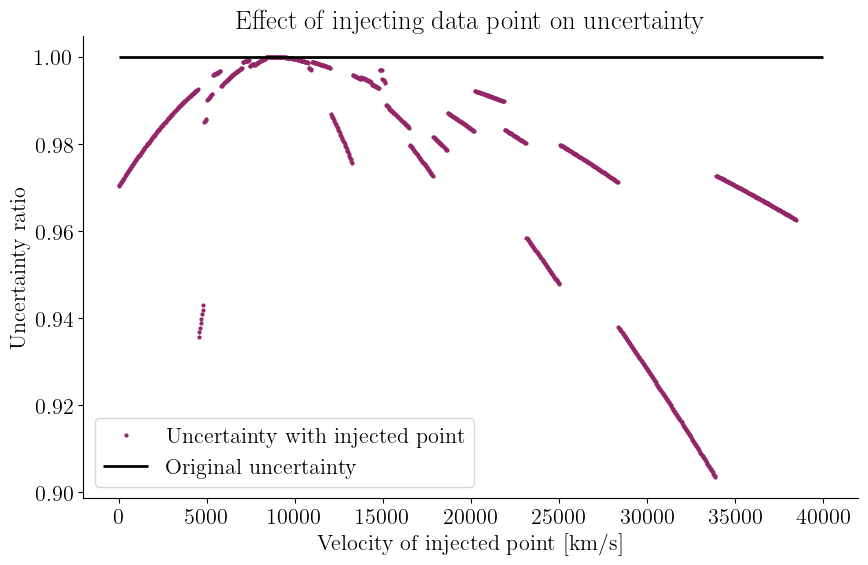

In [78]:
weights = HUBBLE_DATA["e_distance"]**2

fig, ax = plt.subplots(figsize=(10, 6))

error_orig = np.sqrt(polyfit_cov[0, 0])
ax.plot(Ex, errors/error_orig, "o", ms=2, label="Uncertainty with injected point")
ax.hlines(1.0, 0, 40000, color="black", linewidth=2, label="Original uncertainty")

ax.set_ylabel("Uncertainty ratio")
ax.set_xlabel("Velocity of injected point [km/s]")

ax.legend()

ax.set_title("Effect of injecting data point on uncertainty")

plt.savefig("figures/F6.png")
plt.show()